# Check the histogram plotting function and the analytical solution, debug anything not working as expected
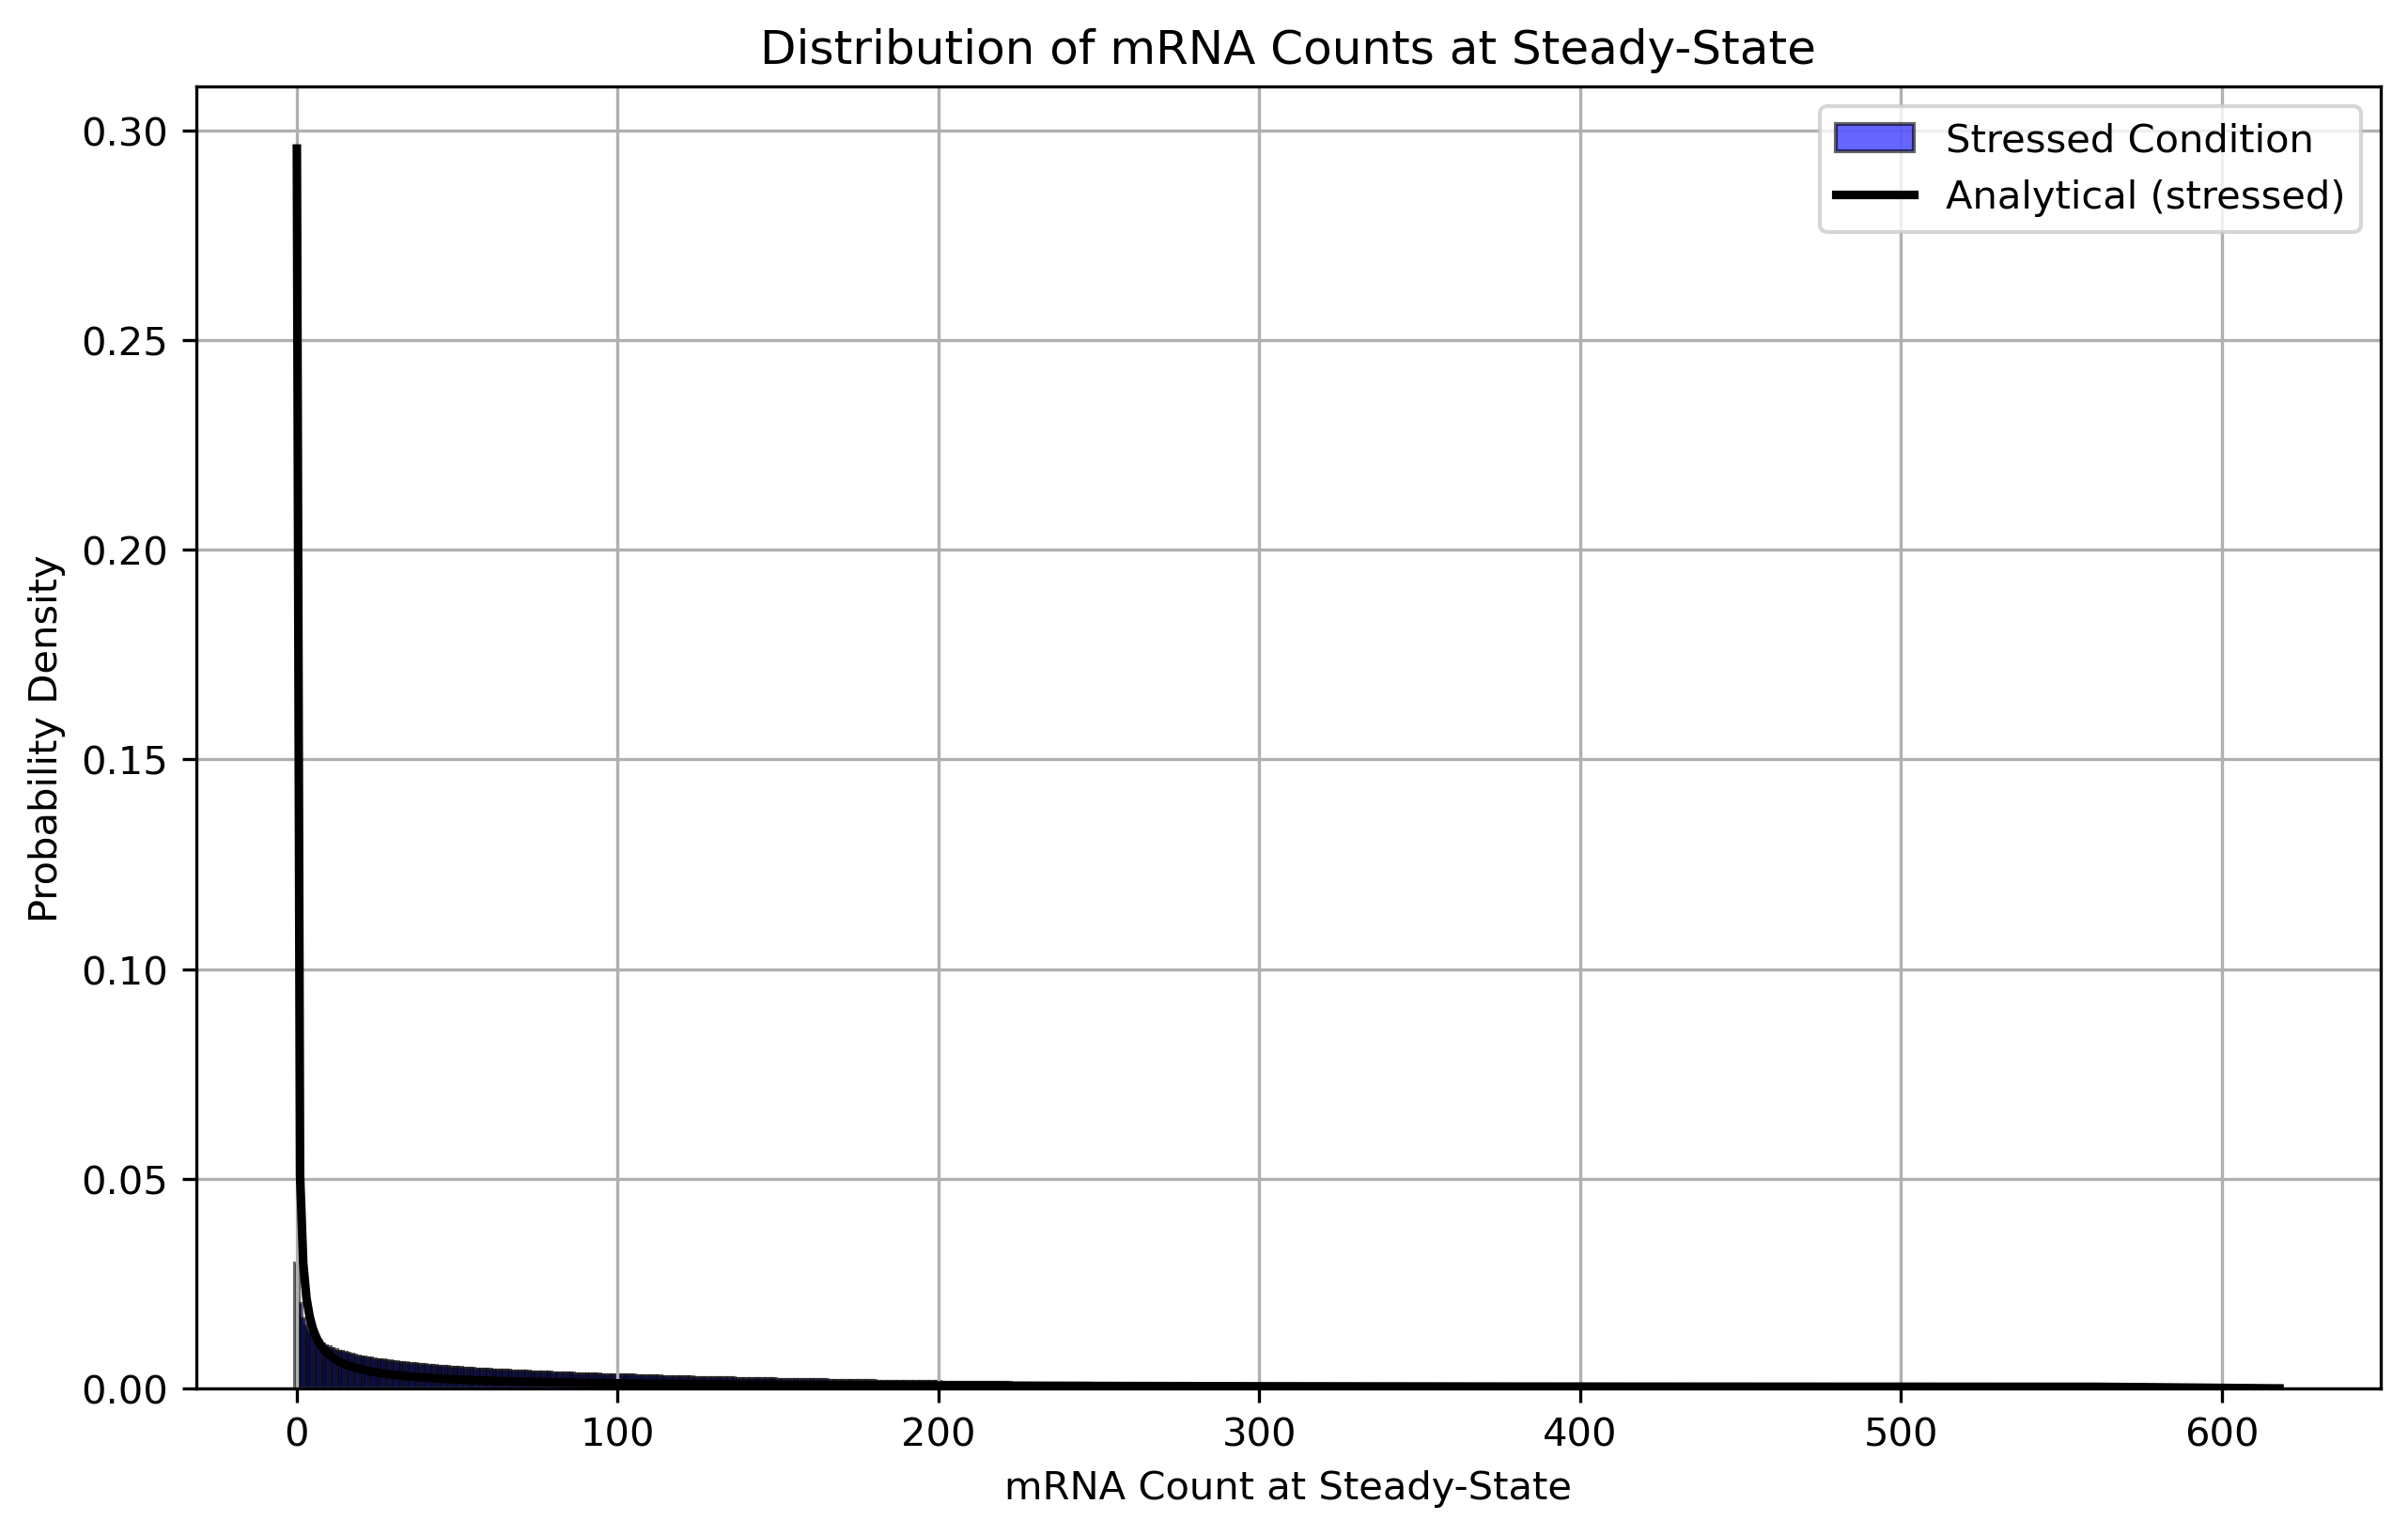

In [16]:
# to simulate data, we can use the following code. this is the basis of IY011_simulation.py.
from simulation.mean_cv_t_ac import find_tilda_parameters
from simulation.julia_simulate_telegraph_model import simulate_telegraph_model
from visualisation.plots import plot_mRNA_dist
import numpy as np
import pandas as pd
import os
import multiprocessing
import os
os.environ.setdefault("PYTHON_JULIACALL_HANDLE_SIGNALS", "yes")
num_cores = multiprocessing.cpu_count()
os.environ["JULIA_NUM_THREADS"] = str(num_cores)  # or set to desired number of threads
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Was the issue with the old code (the code before it was modularised) that was used in the julia pipeline modular tests? 

So running the same simulation as above but with the old code:

Using 12 threads for Julia simulation..


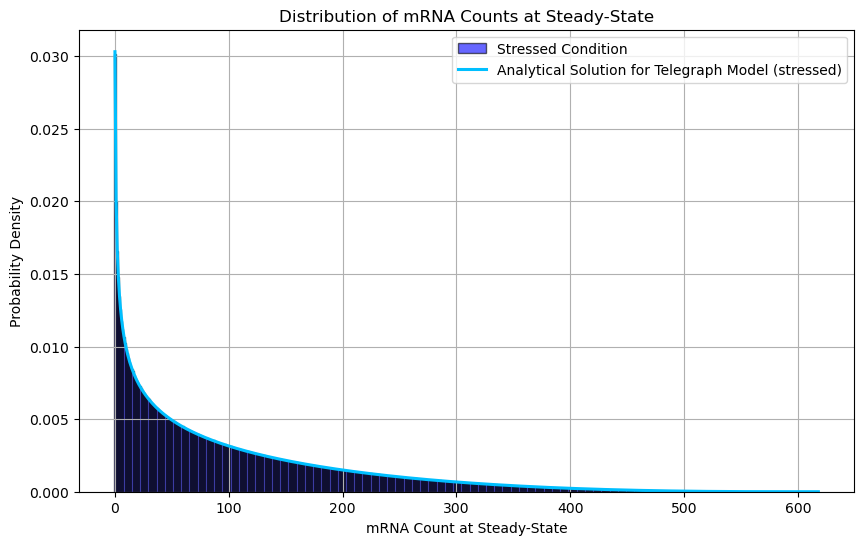

In [10]:
from juliacall import Main as jl
mu_target, t_ac_target, cv_target = 100, 5, 1.0
# Get the parameters using the scaled equations
rho, d, sigma_b, sigma_u = find_tilda_parameters(mu_target, t_ac_target, cv_target)
# print(f"Parameters: ρ={rho:.6f}, d={d:.6f}, σ_b={sigma_b:.6f}, σ_u={sigma_u:.6f}")

# Prepare parameter sets
parameter_sets = [{
    'sigma_b': sigma_b,
    'sigma_u': sigma_u,
    'rho': rho,
    'd': d,
    'label': 0
}]

# Set time points - longer simulation for better autocorrelation estimation
time_points = np.arange(0, 10_000, 1.0)
size = 1000
# Python → Julia conversion handled automatically
jl.parameter_sets = parameter_sets
jl.time_points = time_points

# Run the simulation in Julia
jl.seval(f'df = simulate_telegraph_model(parameter_sets, time_points, {size})')

# Convert Julia DataFrame directly to Python
labels = np.array(jl.seval('Int64.(df.label)'))
counts_matrix = np.array(jl.seval('Int64.(Matrix(df[:, Not(:label)]))'))

# Create pandas DataFrame
df_labels = pd.DataFrame(labels, columns=['label'])
df_counts = pd.DataFrame(counts_matrix, columns=[f"time_{ti}" for ti in time_points])
df = pd.concat([df_labels, df_counts], axis=1)

# Plot data distribution
fig, ax = plot_mRNA_dist(parameter_sets, df_counts, kde=False)

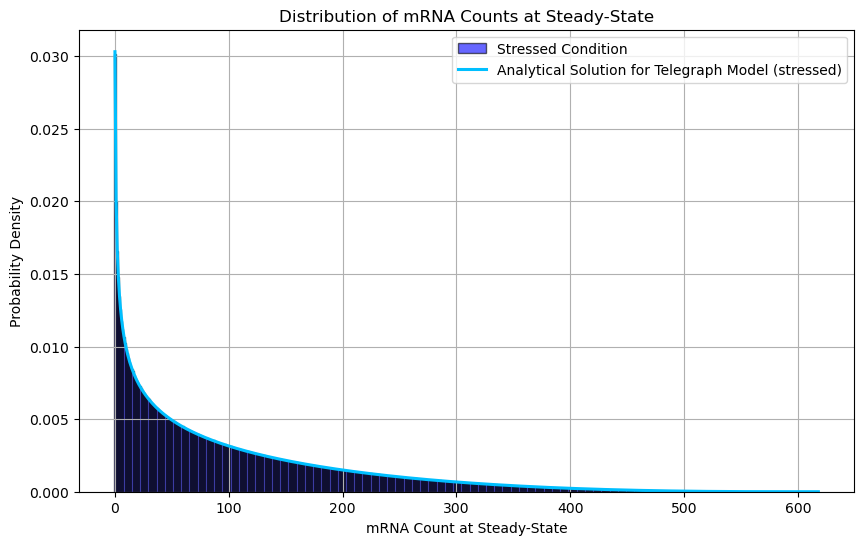

In [11]:
# check that the label dropping error trap works
fig, ax = plot_mRNA_dist(parameter_sets, df, kde=False)

then run some simulations using the new, modularised code to see if the histogram plotting and analytical solution work as expected.

Using 12 threads for Julia simulation..


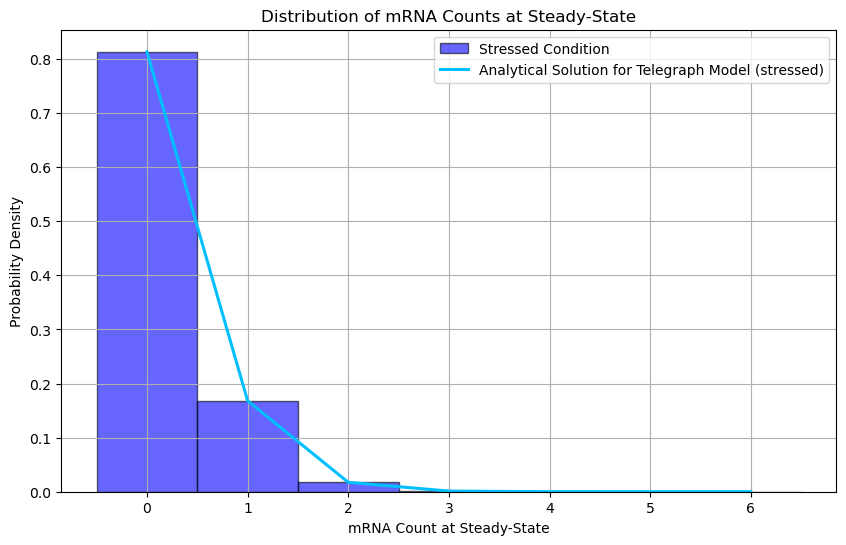

In [12]:
mu_target, t_ac_target, cv_target = 100, 5, 1.0
sigma_b, sigma_u, rho, d = find_tilda_parameters(mu_target, t_ac_target, cv_target)
# Prepare parameter sets
parameter_sets = [{
    'sigma_b': sigma_b,
    'sigma_u': sigma_u,
    'rho': rho,
    'd': d,
    'label': 0
}]
time_points = np.arange(0, 10000, 1.0)
size = 1000
df = simulate_telegraph_model(parameter_sets, time_points, size)
df.drop(columns=['label'], errors='ignore', inplace=True) # drop in-place if it exists, do nothing otherwise
fig, ax = plot_mRNA_dist(parameter_sets, df, kde=False)

Plot a few more that encountered issues...

Using 12 threads for Julia simulation..


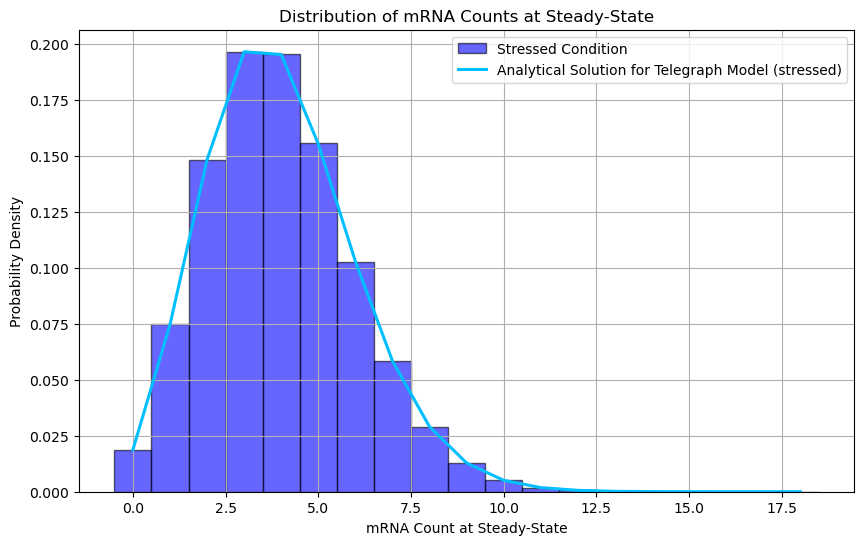

In [13]:
mu_target, t_ac_target, cv_target = 100, 1, 0.5
sigma_b, sigma_u, rho, d = find_tilda_parameters(mu_target, t_ac_target, cv_target)
# Prepare parameter sets
parameter_sets = [{
    'sigma_b': sigma_b,
    'sigma_u': sigma_u,
    'rho': rho,
    'd': d,
    'label': 0
}]
time_points = np.arange(0, 10_000, 1.0)
size = 1000
df = simulate_telegraph_model(parameter_sets, time_points, size)
df.drop(columns=['label'], errors='ignore', inplace=True) # drop in-place if it exists, do nothing otherwise
fig, ax = plot_mRNA_dist(parameter_sets, df, kde=False)

Using 12 threads for Julia simulation..


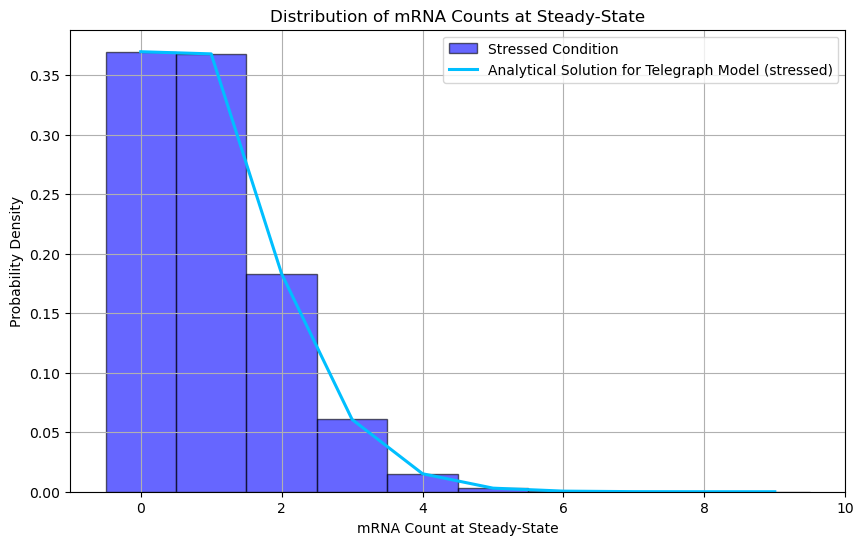

In [14]:
mu_target, t_ac_target, cv_target = 100, 1.0, 1.0
sigma_b, sigma_u, rho, d = find_tilda_parameters(mu_target, t_ac_target, cv_target)
# Prepare parameter sets
parameter_sets = [{
    'sigma_b': sigma_b,
    'sigma_u': sigma_u,
    'rho': rho,
    'd': d,
    'label': 0
}]
time_points = np.arange(0, 10000, 1.0)
size = 1000
df = simulate_telegraph_model(parameter_sets, time_points, size)
df.drop(columns=['label'], errors='ignore', inplace=True) # drop in-place if it exists, do nothing otherwise
fig, ax = plot_mRNA_dist(parameter_sets, df, kde=False)

Using 12 threads for Julia simulation..


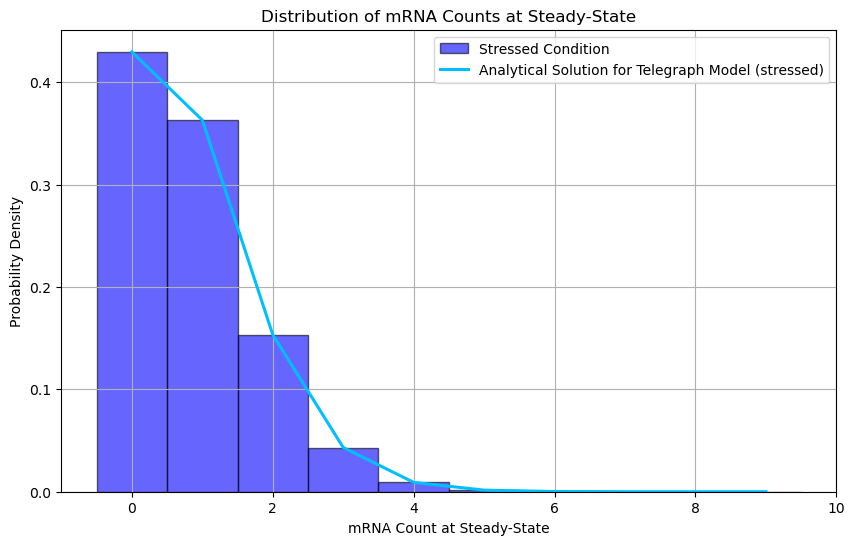

In [15]:
mu_target, t_ac_target, cv_target = 100, 5.0, 0.5
sigma_b, sigma_u, rho, d = find_tilda_parameters(mu_target, t_ac_target, cv_target)
# Prepare parameter sets
parameter_sets = [{
    'sigma_b': sigma_b,
    'sigma_u': sigma_u,
    'rho': rho,
    'd': d,
    'label': 0
}]
time_points = np.arange(0, 10000, 1.0)
size = 1000
df = simulate_telegraph_model(parameter_sets, time_points, size)
df.drop(columns=['label'], errors='ignore', inplace=True) # drop in-place if it exists, do nothing otherwise
fig, ax = plot_mRNA_dist(parameter_sets, df, kde=False)

There's a possibility for the distribution function to be affected by a mis-interpretation of the label column as mRNA counts. But there's an error trap in place in the function to prevent this.

In [14]:
df.head()

label  time_0.0  time_1.0  time_2.0  time_3.0  time_4.0  time_5.0  \
0      0         0         0         0         0         0         0   
1      0         0         1         1         0         0         1   
2      0         0         1         1         1         2         3   
3      0         0         0         0         1         1         0   
4      0         0         1         0         1         2         2   

   time_6.0  time_7.0  time_8.0  ...  time_9990.0  time_9991.0  time_9992.0  \
0         0         0         0  ...            2            3            1   
1         1         1         1  ...            0            1            1   
2         1         2         2  ...            1            0            0   
3         0         0         0  ...            0            0            1   
4         2         1         2  ...            0            0            0   

   time_9993.0  time_9994.0  time_9995.0  time_9996.0  time_9997.0  \
0            1            2            3            1            2   
1            1            2            2            1            1   
2            0            0            0            0            1   
3            1            1            0            0            0   
4            1            2            2            2            1   

   time_9998.0  time_9999.0  
0            2            2  
1            1            1  
2            0            0  
3            0            0  
4            1            2  

[5 rows x 10001 columns]

In [15]:
df.drop(columns=['label'], errors='ignore', inplace=True) # drop in-place if it exists, do nothing otherwise
df.head()

time_0.0  time_1.0  time_2.0  time_3.0  time_4.0  time_5.0  time_6.0  \
0         0         0         0         0         0         0         0   
1         0         1         1         0         0         1         1   
2         0         1         1         1         2         3         1   
3         0         0         0         1         1         0         0   
4         0         1         0         1         2         2         2   

   time_7.0  time_8.0  time_9.0  ...  time_9990.0  time_9991.0  time_9992.0  \
0         0         0         0  ...            2            3            1   
1         1         1         0  ...            0            1            1   
2         2         2         2  ...            1            0            0   
3         0         0         1  ...            0            0            1   
4         1         2         0  ...            0            0            0   

   time_9993.0  time_9994.0  time_9995.0  time_9996.0  time_9997.0  \
0            1            2            3            1            2   
1            1            2            2            1            1   
2            0            0            0            0            1   
3            1            1            0            0            0   
4            1            2            2            2            1   

   time_9998.0  time_9999.0  
0            2            2  
1            1            1  
2            0            0  
3            0            0  
4            1            2  

[5 rows x 10000 columns]

In [17]:
import os
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

from utils.steady_state import find_steady_state
from utils.data_processing import _safe_slice
from simulation.julia_simulate_telegraph_model import simulate_telegraph_model

# --- Analytical PMF (correct scaling: Beta(a,b) with a=σ_b/d, b=σ_u/d) ---
def telegraph_mrna_pmf(rho, sigma_b, sigma_u, d, max_n=2000, tol=1e-10):
    lam = rho / d
    a, b = sigma_b / d, sigma_u / d              # << key fix
    B = mp.beta(a, b)

    def Pn(n):
        nf = mp.factorial(n)
        integrand = lambda x: mp.e**(-lam*x) * (lam*x)**n / nf * x**(a-1) * (1-x)**(b-1) / B
        return mp.quad(integrand, [0, 1])

    pmf, tot = [], mp.mpf('0')
    for n in range(max_n):
        p = Pn(n); pmf.append(p); tot += p
        if tot > (1 - tol) and n > 10:
            break
    pmf = np.array([float(p/tot) for p in pmf], dtype=float)
    n = np.arange(len(pmf))
    return n, pmf

# --- Analytical moments for Beta–Poisson mixture (useful for checks) ---
def analytical_mean_var(rho, sigma_b, sigma_u, d):
    lam = rho / d
    a, b = sigma_b / d, sigma_u / d
    Ex = a / (a + b)
    Varx = (a * b) / ((a + b)**2 * (a + b + 1))
    mean = lam * Ex
    var = lam * Ex + (lam**2) * Varx
    return mean, var

# --- Plot one regime (simulate → steady-state histogram → analytical overlay) ---
def run_regime(name, rho, sigma_b, sigma_u, d, n_cells=2000, t_end=5000.0, save_dir="sanity_check_plots"):
    os.makedirs(save_dir, exist_ok=True)

    params = [{'rho': rho, 'sigma_b': sigma_b, 'sigma_u': sigma_u, 'd': d, 'label': 0}]
    time_points = np.arange(0.0, t_end, 1.0)

    # simulate
    traj = simulate_telegraph_model(params, time_points, n_cells)

    # steady state slice
    _, idx_ss = find_steady_state(params[0])
    ss_traj = _safe_slice(traj, idx_ss)
    flat = ss_traj.flatten()

    # histogram bins centred on integers
    max_count = int(max(10, flat.max())) + 5
    bins = np.arange(0, max_count + 1.5) - 0.5

    # analytical overlay
    n, pmf = telegraph_mrna_pmf(rho, sigma_b, sigma_u, d, max_n=max_count + 10)

    # empirical moments (steady state)
    emp_mean = float(np.mean(flat))
    emp_var = float(np.var(flat))
    emp_cv = float(np.sqrt(emp_var) / emp_mean) if emp_mean > 0 else np.nan

    # analytical moments
    ana_mean, ana_var = analytical_mean_var(rho, sigma_b, sigma_u, d)
    ana_cv = float(np.sqrt(ana_var) / ana_mean) if ana_mean > 0 else np.nan

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(flat, bins=bins, density=True, alpha=0.6, color='royalblue',
            edgecolor='black', label=f'{name} (simulated)')
    ax.plot(n, pmf, color='black', lw=2.2, label='Analytical (Beta–Poisson)')

    ax.set_xlabel("mRNA Count at Steady-State")
    ax.set_ylabel("Probability Density")
    ax.set_title(f"Telegraph model — {name}")
    ax.legend()
    ax.grid(True)

    out = os.path.join(save_dir, f"{name.replace(' ', '_')}.png")
    fig.savefig(out, dpi=300, bbox_inches='tight')
    plt.close(fig)

    # print a short summary
    print(f"\n=== {name} ===")
    print(f"ρ={rho}, σ_b={sigma_b}, σ_u={sigma_u}, d={d}")
    print(f"Empirical:  mean={emp_mean:.3f}, var={emp_var:.3f}, CV={emp_cv:.3f}")
    print(f"Analytical: mean={ana_mean:.3f}, var={ana_var:.3f}, CV={ana_cv:.3f}")
    print(f"Figure: {out}")

# --- Three regimes -------------------------------------------------------------
if __name__ == "__main__":
    # 1) Bursting regime: σ_b ≪ d, σ_u ≫ d  (zero-heavy / potentially bimodal)
    run_regime(
        name="Bursting regime",
        rho=20.0,     # ON transcription
        sigma_b=0.05, # OFF→ON (slow)
        sigma_u=5.0,  # ON→OFF (fast)
        d=1.0
    )

    # 2) Fast-switching regime: σ_b, σ_u ≫ d  (approximately Poisson)
    run_regime(
        name="Fast-switching regime",
        rho=20.0,
        sigma_b=30.0,
        sigma_u=30.0,
        d=1.0
    )

    # 3) Intermediate regime: σ_b ~ d, σ_u ~ d  (asymmetric, right-skewed)
    run_regime(
        name="Intermediate regime",
        rho=15.0,
        sigma_b=1.0,
        sigma_u=1.5,
        d=1.0
    )

    print("\nDone. Check the 'sanity_check_plots' directory for figures.")


Using 12 threads for Julia simulation..

=== Bursting regime ===
ρ=20.0, σ_b=0.05, σ_u=5.0, d=1.0
Empirical:  mean=0.198, var=0.847, CV=4.646
Analytical: mean=0.198, var=0.846, CV=4.645
Figure: sanity_check_plots/Bursting_regime.png
Using 12 threads for Julia simulation..

=== Fast-switching regime ===
ρ=20.0, σ_b=30.0, σ_u=30.0, d=1.0
Empirical:  mean=9.999, var=11.638, CV=0.341
Analytical: mean=10.000, var=11.639, CV=0.341
Figure: sanity_check_plots/Fast-switching_regime.png
Using 12 threads for Julia simulation..

=== Intermediate regime ===
ρ=15.0, σ_b=1.0, σ_u=1.5, d=1.0
Empirical:  mean=5.999, var=21.433, CV=0.772
Analytical: mean=6.000, var=21.429, CV=0.772
Figure: sanity_check_plots/Intermediate_regime.png

Done. Check the 'sanity_check_plots' directory for figures.
